![cyber_photo](cyber_photo.jpg)

Cyber threats are a growing concern for organizations worldwide. These threats take many forms, including malware, phishing, and denial-of-service (DOS) attacks, compromising sensitive information and disrupting operations. The increasing sophistication and frequency of these attacks make it imperative for organizations to adopt advanced security measures. Traditional threat detection methods often fall short due to their inability to adapt to new and evolving threats. This is where deep learning models come into play.

Deep learning models can analyze vast amounts of data and identify patterns that may not be immediately obvious to human analysts. By leveraging these models, organizations can proactively detect and mitigate cyber threats, safeguarding their sensitive information and ensuring operational continuity.

As a cybersecurity analyst, you identify and mitigate these threats. In this project, you will design and implement a deep learning model to detect cyber threats. The BETH dataset simulates real-world logs, providing a rich source of information for training and testing your model. The data has already undergone preprocessing, and we have a target label, `sus_label`, indicating whether an event is malicious (1) or benign (0).

By successfully developing this model, you will contribute to enhancing cybersecurity measures and protecting organizations from potentially devastating cyber attacks.


### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

In [26]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
import os
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # uncomment to use sklearn

In [27]:
# Load preprocessed data
train_df = pd.read_csv('data/labelled_train.csv')
test_df = pd.read_csv('data/labelled_test.csv')
val_df = pd.read_csv('data/labelled_validation.csv')

# View the first 5 rows of training set
train_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [28]:
# Dataset shapes
print("Train set: ", train_df.shape)
print("Validation set: ", val_df.shape)
print("Test set: ", test_df.shape)

Train set:  (763144, 8)
Validation set:  (188967, 8)
Test set:  (188967, 8)


In [29]:
# Separate features and labels for training, testing, and validation sets
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values
X_test = test_df.drop('sus_label', axis=1).values
y_test = test_df['sus_label'].values
X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

# Save model features
feature_names = train_df.drop('sus_label', axis=1).columns.tolist()
print(feature_names)
joblib.dump(feature_names, "models/features.pkl")
# print("Features saved.")

['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'argsNum', 'returnValue']


['models/features.pkl']

In [30]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test and validation data using the fitted scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Save scaler
joblib.dump(scaler, "models/scaler.pkl")
print("Scaler saved.")

Scaler saved.


In [31]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
print(X_train_tensor)

tensor([[-3.3013,  0.2668, -0.8491,  ...,  1.7840,  1.7361, -0.0550],
        [-3.3013,  0.2668, -0.8491,  ...,  1.7840, -1.2470, -0.0550],
        [-3.3013,  0.2668, -0.8491,  ...,  1.7840, -1.9927, -0.0550],
        ...,
        [ 0.2356,  0.2342,  2.3587,  ..., -0.5871, -1.9927, -0.0550],
        [ 0.2362,  0.2348, -0.8491,  ..., -0.5871, -1.9927, -0.0550],
        [ 0.1505,  0.1485, -0.8491,  ..., -0.5871, -1.2470, -0.0550]])


In [32]:
# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),  # First fully connected layer
    nn.ReLU(),  # ReLU activation
    # nn.BatchNorm1d(64), # stabilizes training and reduces overfitting
    nn.Dropout(p=0.3), 
    nn.Linear(64, 32),  # Second fully connected layer
    nn.ReLU(),  # ReLU activation
    # nn.BatchNorm1d(64),
    nn.Dropout(p=0.3), 
    nn.Linear(32, 1),  # Third fully connected layer
    nn.Sigmoid()  # Sigmoid activation for binary classification
)
print("Model created.")

Model created.


In [33]:
# Initialize the loss function and optimizer
# criterion = nn.CrossEntropyLoss() # multiple classes
# optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss() # 2 classes
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

"""
try BCELoss() - Binary Cross Entropy Loss for binary classification, meaning the model only have 2 classes. This will provide accurate and higher probability.

try optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

Adam computes individual adaptive learning rates for different parameters from 
estimates of first and second moments of the gradients. This helps in faster convergence and better handling of sparse gradients. Adam is generally better than SGD for most problems as it adapts the learning rate for each parameter, which can lead to better performance and faster training.
"""

# Create DataLoaders
batch_size = 4096

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [34]:
# Training loop
num_epoch = 10
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/10 - Train Loss: 0.1506 - Val Loss: 0.0051
Epoch 2/10 - Train Loss: 0.0058 - Val Loss: 0.0035
Epoch 3/10 - Train Loss: 0.0041 - Val Loss: 0.0034
Epoch 4/10 - Train Loss: 0.0034 - Val Loss: 0.0035
Epoch 5/10 - Train Loss: 0.0031 - Val Loss: 0.0035
Epoch 6/10 - Train Loss: 0.0030 - Val Loss: 0.0036
Epoch 7/10 - Train Loss: 0.0029 - Val Loss: 0.0035
Epoch 8/10 - Train Loss: 0.0029 - Val Loss: 0.0036
Epoch 9/10 - Train Loss: 0.0027 - Val Loss: 0.0036
Epoch 10/10 - Train Loss: 0.0027 - Val Loss: 0.0035


In [35]:
# Model Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for efficiency
    y_predict_train = model(X_train_tensor) #.round()  # Predict on training data and round the outputs
    y_predict_test = model(X_test_tensor) #.round()  # Predict on test data and round the outputs
    y_predict_val = model(X_val_tensor) #.round()  # Predict on validation data and round the outputs

    # Add split labels
    train_df["split"] = "train"
    val_df["split"] = "validation"
    test_df["split"] = "test"

    # Combine datasets
    all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    # Prepare features (DO NOT refit scaler)
    X_all = all_df.drop(["sus_label", "split"], axis=1)
    X_all_scaled = scaler.transform(X_all)
    X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)

    # Run model
    all_probs = model(X_all_tensor).squeeze().numpy()
    all_preds = (all_probs >= 0.5).astype(int)

    # Attach predictions
    all_df["predicted_label"] = all_preds
    all_df["prediction_probability"] = all_probs
    all_df["prediction_correct"] = (
        all_df["predicted_label"] == all_df["sus_label"]
    ).astype(int)

all_df.head()

c:\Users\My Pham\Documents\Docs\Data Science\Datacamp\Introduction to Deep Learning with PyTorch\Detecting Cybersecurity Threats Using Deep Learning Project\Final Version\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label,split,predicted_label,prediction_probability,prediction_correct
0,381,7337,1,100,4026532231,5,0,1,train,0,0.160326,0
1,381,7337,1,100,4026532231,1,0,1,train,0,0.333070,0
2,381,7337,1,100,4026532231,0,0,1,train,0,0.199003,0
3,7347,7347,7341,0,4026531840,2,-2,1,train,0,0.002377,0
4,7347,7347,7341,0,4026531840,4,0,1,train,0,0.001045,0


In [36]:
# Save predictions
all_df.to_csv("output/all_predictions.csv", index=False)
print("Predictions saved.")

Predictions saved.


In [37]:
# Calculate accuracy using torchmetrics
accuracy = Accuracy(task="binary")

train_accuracy = accuracy(y_predict_train, y_train_tensor).item()
test_accuracy = accuracy(y_predict_test, y_test_tensor).item()
val_accuracy = accuracy(y_predict_val, y_val_tensor).item()
# Calculate the accuracy using sklearn
# train_accuracy = accuracy_score(y_train_tensor, y_predict_train)
# val_accuracy = accuracy_score(y_val_tensor, y_predict_val)
# test_accuracy = accuracy_score(y_test_tensor, y_predict_test)

print("Training accuracy: {0}".format(train_accuracy))
print("Validation accuracy: {0}".format(val_accuracy))
print("Testing accuracy: {0}".format(test_accuracy))

Training accuracy: 0.9996422529220581
Validation accuracy: 0.9999523758888245
Testing accuracy: 0.9459800124168396


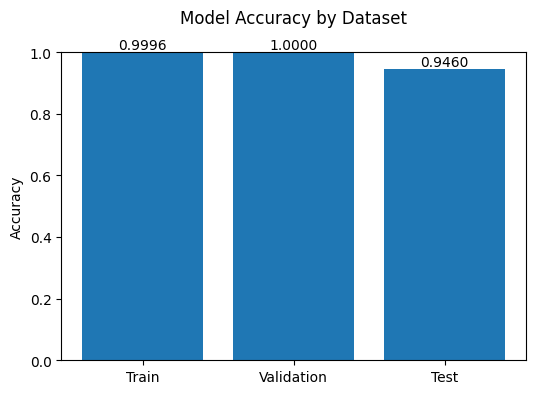

In [38]:
# Visualize accuracy scores
labels = ["Train", "Validation", "Test"]
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(6,4))
plt.bar(labels, accuracies)
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Dataset\n")  # add two blank lines under the title

# Add extra space between the title and chart
plt.subplots_adjust(top=0.88)  # increase top margin (0.88 leaves room for title)

# Show values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha="center")

# Save the figure to reports/
os.makedirs('reports', exist_ok=True)
plt.savefig(os.path.join('reports', 'accuracy_scores.png'), dpi=300, bbox_inches='tight')

plt.show()

In [39]:
# Confusion matrix for validation set
val_subset = all_df[all_df["split"] == "validation"]

cm_val = confusion_matrix(
    val_subset["sus_label"],
    val_subset["predicted_label"]
)

print("Validation Confusion Matrix:")
print(cm_val)

Validation Confusion Matrix:
[[188181      0]
 [     9    777]]


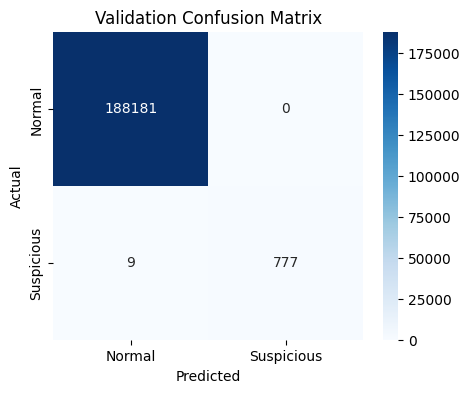

In [40]:
# Visualize CM - val set
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Suspicious"],
    yticklabels=["Normal", "Suspicious"]
)
plt.title("Validation Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Save the figure to reports/
os.makedirs('reports', exist_ok=True)
plt.savefig(os.path.join('reports', 'val_confusion_matrix.png'), dpi=300, bbox_inches='tight')

plt.show()

In [41]:
# Confusion matrix for test set
test_subset = all_df[all_df["split"] == "test"]

cm_test = confusion_matrix(
    test_subset["sus_label"],
    test_subset["predicted_label"]
)

print("Test Confusion Matrix:")
print(cm_test)

Test Confusion Matrix:
[[ 17508      0]
 [ 10208 161251]]


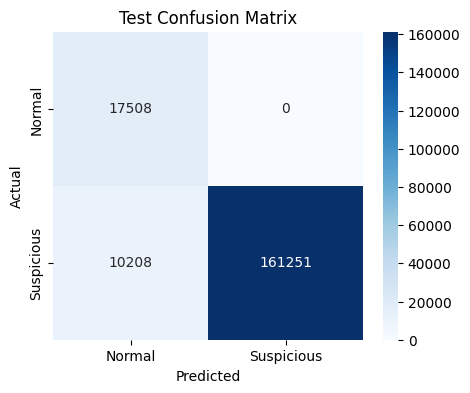

In [42]:
# Visualize CM - test set
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Suspicious"],
    yticklabels=["Normal", "Suspicious"]
)
plt.title("Test Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

# Save the figure to reports/
os.makedirs('reports', exist_ok=True)
plt.savefig(os.path.join('reports', 'test_confusion_matrix.png'), dpi=300, bbox_inches='tight')

plt.show()

In [43]:
# Classification report for validation set
val_subset = all_df[all_df["split"] == "validation"]

print(classification_report(
    val_subset["sus_label"],
    val_subset["predicted_label"],
    target_names=["Normal", "Suspicious"]
))

# Save report
with open("reports/classification_report_validation.txt", "w") as f:
    f.write(classification_report(
        val_subset["sus_label"],
        val_subset["predicted_label"],
        target_names=["Normal", "Suspicious"]
    ))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    188181
  Suspicious       1.00      0.99      0.99       786

    accuracy                           1.00    188967
   macro avg       1.00      0.99      1.00    188967
weighted avg       1.00      1.00      1.00    188967



In [44]:
# Classification report for test set
test_subset = all_df[all_df["split"] == "test"]

print(classification_report(
    test_subset["sus_label"],
    test_subset["predicted_label"],
    target_names=["Normal", "Suspicious"]
))

# Save report
with open("reports/classification_report_test.txt", "w") as f:
    f.write(classification_report(
        test_subset["sus_label"],
        test_subset["predicted_label"],
        target_names=["Normal", "Suspicious"]
    ))

              precision    recall  f1-score   support

      Normal       0.63      1.00      0.77     17508
  Suspicious       1.00      0.94      0.97    171459

    accuracy                           0.95    188967
   macro avg       0.82      0.97      0.87    188967
weighted avg       0.97      0.95      0.95    188967



In [45]:
# Save model
torch.save(model.state_dict(), "models/model.pt")
print("Model saved.")

Model saved.
